# Lab assignment - Image segmentation applied to remote sensing (basic to advanced)
**Master 2 GeoData Science**

*2021-2022*

## Introduction
For this lab, we will again work with the **Scikit-image** library and also the **OpenCV** library. The objective is to experiment some basic and advanced methods for image segmentation applied to some selected remote sensing images. This lab assignment includes 4 exercises: 

* Exo1: Manual thesholding and histogram-based thresholding for segmentation
* Exo2: Clustering-based segmentation
* Exo3: Watershed segmentation and dealing with over-segmentation
* Exo4: Efficient Graph-Based Image Segmentation by Felzenszwalb & Huttenlocher (paper that you like alot !!!)

**Submit your work on Moodle by November 20 !!! Remember that your work should contain codes, results as well as your analysis or remark on the obtained results**

Before starting, if you prefer to work on image files from your Drive, let mount your drive to allow Colab to acess to your Google Drive. Otherwise, upload the image files at each time you connect to the Colab server.

In [1]:
# Import all the libraries needed for this session
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import graph, data, io, segmentation, color

from skimage.measure import regionprops
from skimage import draw
from skimage.segmentation import felzenszwalb
import cv2 as cv2
from skimage.morphology import watershed
from skimage.morphology import extrema
from scipy.ndimage.morphology import morphological_gradient
from skimage.feature import peak_local_max
from scipy import ndimage
from PIL import Image
from scipy.ndimage.measurements import label

Let's first open and visualize a Postdam RGB 2 image (TIFF file) to make sure that everything goes well. You would be then ready to tackle the exercises.

In [2]:
#defining reusable functions

#function to convertrgb to gray
def to_gray(img_rgb):
    red = img_rgb[:,:,0]
    green = img_rgb[:,:,1]
    blue = img_rgb[:,:,2]
    gray = 0.298*red + 0.587*green + 0.114*blue
    return gray

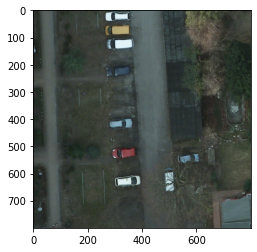

In [3]:
# Open and vizualize the RGB image "potsdam_RGB_2.tiff" (Image source: https://www2.isprs.org/commissions/comm2/wg4/benchmark/2d-sem-label-potsdam/)
potsdam_rgb = tiff.imread("potsdam_RGB_2.tiff")
potsdam_rgb = np.asarray(potsdam_rgb)
plt.imshow(potsdam_rgb)
plt.show()

### **Exo 1: Threshold-based segmentation**

(Note that the segmentation results using thresholding methods are not perfect!) 

#### *Question 1.1)*
Compute and visualize a gray-scale version of potsdam_rgb using the formula 

```
potsdam_gray = 0.298xRed + 0.587xGreen + 0.114xBlue
```

and round the values to integers.

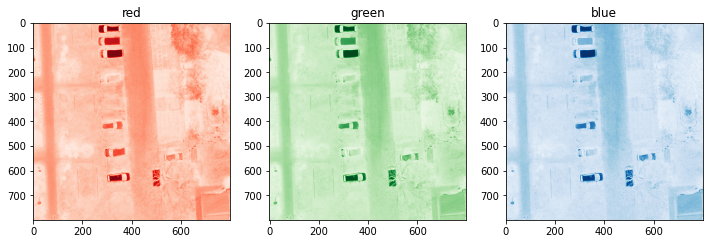

In [4]:
# Your work here
potsdam_red = potsdam_rgb[:,:,0]
potsdam_green = potsdam_rgb[:,:,1]
potsdam_blue = potsdam_rgb[:,:,2]

plt.figure(figsize=(12,10))
plt.subplot(131)
plt.imshow(potsdam_red, cmap="Reds")
plt.title("red")
plt.subplot(132)
plt.imshow(potsdam_green,cmap="Greens")
plt.title("green")
plt.subplot(133)
plt.imshow(potsdam_blue,cmap="Blues")
plt.title("blue")

plt.show()

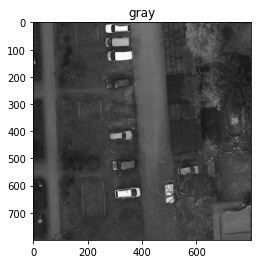

In [5]:
potsdam_gray = to_gray(potsdam_rgb)
potsdam_gray.astype(int)
plt.imshow(potsdam_gray,cmap='gray')
plt.title("gray")
plt.show()

#### *Question 1.2)*

Compute and visualize the histogram of gray values of *potsdam_gray*.

To compute the histogram, you can use the Numpy function:

```
histogram, bins_ = np.histogram(img, bins)
```

and to visualize the histogram, plot it with the Matplotlib function:

```
plt.bar(X, Y)
```




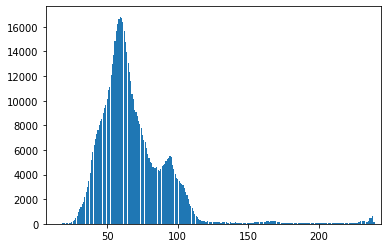

In [6]:
hist, bin_edges = np.histogram(potsdam_gray, bins = 256)
plt.bar(bin_edges[:-1], hist)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()

#### *Question 1.3)*

Based on the histogram of *potsdam_gray*, extract the light-gray cars by thresholding the gray scale image. 

Can we do the same for the black car?

Note that the results won't be perfect.

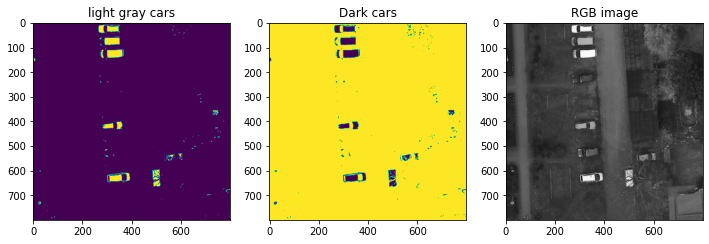

In [7]:
# Your work here
#for light color cars
light_gray =potsdam_gray>130
dark_gray =potsdam_gray<120

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(light_gray)                  
plt.title("light gray cars")
plt.subplot(132)
plt.imshow(dark_gray)
plt.title("Dark cars")
plt.subplot(133)
plt.imshow(potsdam_gray,cmap="gray")
plt.title("RGB image")
plt.show()

No, I was not able do the same process of extraction for black car based on thresholding. I believe the reason is that the other territory is also more or less of similar intensity that make its difficult for the extraction of only black car. So, when we try to segment all the other dark features than cars are also segmented in the image.

#### *Question 1.4)*

What if we want to segment the red car? This time, we need the RGB version of this image.

Apply different threhsold values for each channel (For example: Red>120, Green<80 and Blue < 80)

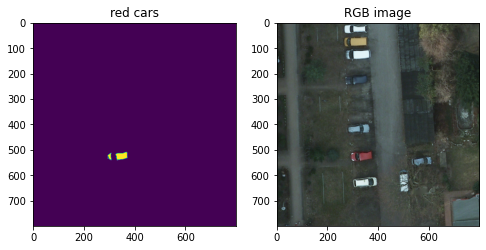

In [8]:
# Your work here
red_car=np.logical_and(potsdam_red>120, potsdam_green<90, potsdam_blue < 90)

#plotting
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(red_car)
plt.title("red cars")
plt.subplot(122)
plt.imshow(potsdam_rgb)
plt.title("RGB image")
plt.show()

### **Exo 2: Clustering-based methods for segmentation**

Open and visualize the image "dolphins.jpg" 
(Image source: https://www.pexels.com/fr-fr/photo/mer-eau-ocean-ete-4321166/)



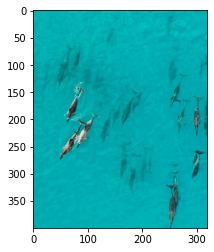

In [9]:
dolphins_rgb = plt.imread("dolphins.jpg")
dolphins_rgb = np.asarray(dolphins_rgb)     #read as array
dolphins_rgb = dolphins_rgb[:,:,0:3]
plt.imshow(dolphins_rgb)
plt.show()

#### *Question 2.1)*

As done previously, try to segment the twelve dolphins using threholds on the three RGB channels.


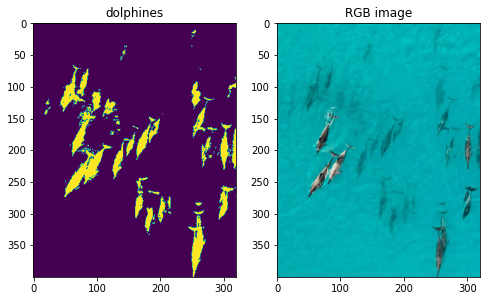

In [10]:
# your work
dolphins_r = dolphins_rgb[:,:,0]
dolphins_g = dolphins_rgb[:,:,1]
dolphins_b = dolphins_rgb[:,:,2]

#using logical or to threshold on each of the bands 
dolphins=np.logical_or(dolphins_r>50,dolphins_g<150,dolphins_b<20)

#plotting
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(dolphins)
plt.title("dolphines")
plt.subplot(122)
plt.imshow(dolphins_rgb)
plt.title("RGB image")
plt.show()

Though random section of threshold was done in above example that gave quite good result but it cannot be considered reliable method for different application cases.

#### *Question 2.2)*
Now, let's perform SLIC super-pixel segmentation using the *segmentation.slic* method with parameters
- compactness 
- number of segments 

Try different different values compactness and number of segments. Which combination helps you to obtain a satisfied superpixel masks ?

/tmp/ipykernel_3664/2389759693.py:6: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  labels = segmentation.slic(im, compactness=c, n_segments=n)


number of SPs: 374
number of SPs: 389
number of SPs: 391
number of SPs: 91
number of SPs: 195
number of SPs: 273


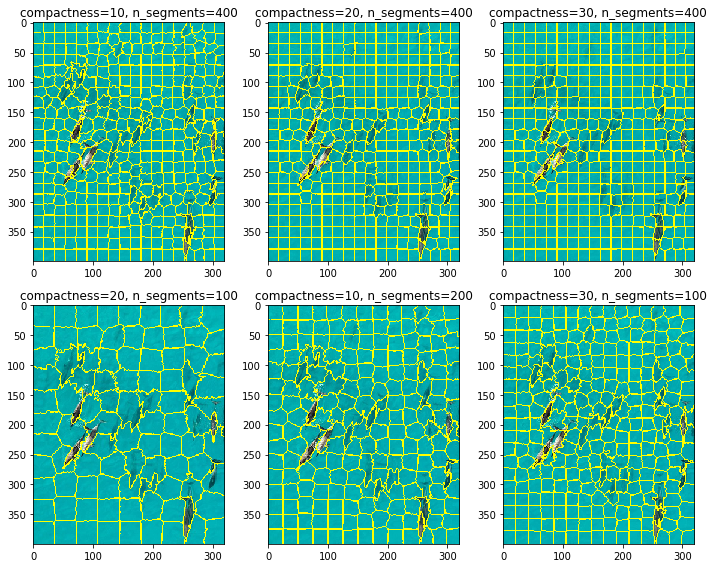

In [11]:
# your work here
from skimage import graph, data, io, segmentation, color

def segement(im,c,n):
    # labels from dolphin image
    labels = segmentation.slic(im, compactness=c, n_segments=n)
    
    #output image
    img_out=segmentation.mark_boundaries(im,labels)
  
    # Print the number of super-pixels 
    print("number of SPs:", np.size(np.unique(labels)))
    return img_out


#plot
plt.figure(figsize=(10,8))
plt.subplot(231)
io.imshow(segement(dolphins_rgb,10,400))
plt.title("compactness=10, n_segments=400")
plt.subplot(232)
io.imshow(segement(dolphins_rgb,20,400))
plt.title("compactness=20, n_segments=400")
plt.subplot(233)
io.imshow(segement(dolphins_rgb,30,400))
plt.title("compactness=30, n_segments=400")
plt.subplot(234)
io.imshow(segement(dolphins_rgb,10,100))
plt.title("compactness=20, n_segments=100")
plt.subplot(235)
io.imshow(segement(dolphins_rgb,10,200))
plt.title("compactness=10, n_segments=200")
plt.subplot(236)
io.imshow(segement(dolphins_rgb,10,300))
plt.title("compactness=30, n_segments=100")
plt.show()

Segmentation was done on my image using k-means clustering. From the documentation it was clear that n_segments in the function refers to the number of labels in the segmented output image whereas compactness balances color and space proximity. Higher values give more weight to space proximity, making superpixel shapes and vice versa. 

Visually better result was achieved for me when small compactness was provided with smaller segment values.

#### *Question 2.3)*

Now, let us try with the clustering methods: first with K-means.

To segment using the K-means method, we will consider two pixels representation:

- RGB values

- RGB value + pixels position

To segment using the K-means algorithm, use the following function:

```
kmeans = KMeans(n_clusters, max_iter=150).fit(X)
segmentation = kmeans.predict(X)
```
where *n_clusters* corresponds to the *k* parameter. Try different values for the parameter *n_clusters*.

**Note: for this question, you can resize the image to 64*64 for faster computation**

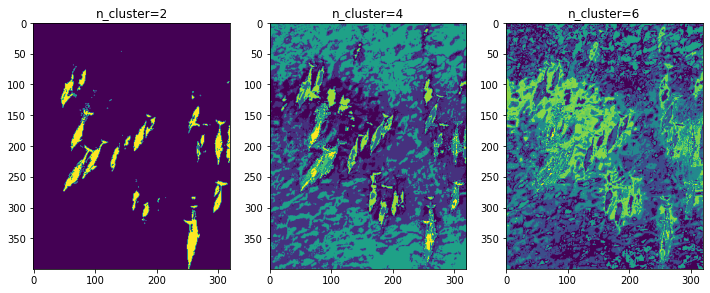

In [12]:
# your work here

def k_mean(n,img,reshape):
    # Convert MxNx3 image into Kx3 where K=MxN
    img2 = img.reshape((-1, reshape))  #-1 reshape means, in this case MxN

    #We convert the unit8 values to float as it is a requirement of the k-means method of OpenCV
    kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=42)
    model = kmeans.fit(img2)
    
    #predicted the outcome of the values
    predicted_values = kmeans.predict(img2)
    segm_image = predicted_values.reshape((img.shape[0], img.shape[1]))
    return segm_image


plt.figure(figsize=(12,10))
plt.subplot(131)
plt.imshow(k_mean(2,dolphins_rgb,3))
plt.title('n_cluster=2')
plt.subplot(132)
plt.imshow(k_mean(8,dolphins_rgb,3))
plt.title('n_cluster=4')
plt.subplot(133)
plt.imshow(k_mean(18,dolphins_rgb,3))
plt.title('n_cluster=6')
plt.show()

Above plots shows the predicted values with variations in the number of clusters assigned for the task. Though higher clustering seems predict the model better with reference to the intensity value but in this case of binary class problem **n_cluster=2** also gave a satisfied result for the segmentation of dolphin.

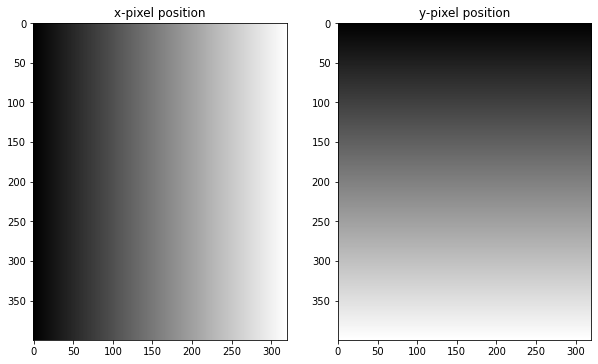

In [13]:
#create a mesh grid then combine both using dstack
x,y = np.meshgrid(range(dolphins_rgb.shape[1]), range(dolphins_rgb.shape[0]))
img_combo = np.dstack((dolphins_rgb, x,y))

#plotting
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(x, cmap='gray')
plt.title('x-pixel position')
plt.subplot(122)
plt.imshow(y, cmap='gray')
plt.title('y-pixel position')
plt.show()

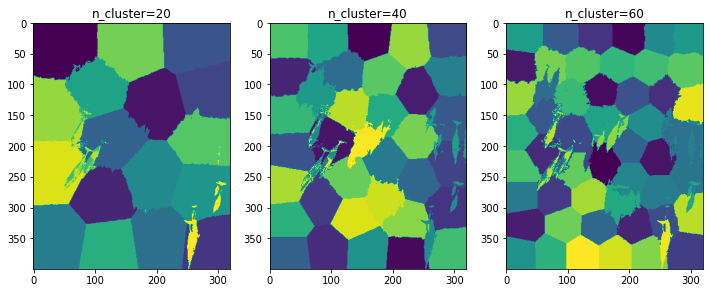

In [14]:
plt.figure(figsize=(12,10))
plt.subplot(131)
plt.imshow(k_mean(20,img_combo,5))
plt.title('n_cluster=20')
plt.subplot(132)
plt.imshow(k_mean(40,img_combo,5))
plt.title('n_cluster=40')
plt.subplot(133)
plt.imshow(k_mean(60,img_combo,5))
plt.title('n_cluster=60')
plt.show()

When clustering method was applied to the input that included the positional layer, the watershed plot as shown above was received. It was seen that in the above case with the inclusion of positional layer, for higher clustering better result is obtained and unlike previous case are able to visually distinguish dolphines with higher cluster numbers.

### **Exo 3: Let's try a more advanced method: Watershed**

###  Watershed segmentation - Reminder

Gray-scale images can be visualized as 3D surfaces: 
- Gray-scale values proportional to altitudes
- *Local minimum:* connected pixels surrounded by pixels of strictly larger gray-levels
- *Catchment basin:* zone of influence of a minimum
- *Watershed lines:* frontiers between catchment basins

#### Question 3.1)

Compute the watershed segmentation of a gradient of *potsdam_gray*. 

For this task, we consider the a Laplacian gradient. To prevent oversegmentation, we consider a smoothed version of *potsdam_gray* image. Let's follow the guide (see also the usage of skimage functions)

1 - Smooth the *potsdam_gray* image and compute its Laplacian gradient:

```
kernel = np.ones((5,5),np.float32)/25
smooth_image = cv2.filter2D(np.uint8(potsdam_gray),-1,kernel)

kernel = (np.array([[0, 1, 0], [1, -4, 1], [0,1,0]])).astype(np.float32)
laplacian_gradient = cv2.filter2D(np.uint8(smooth_image),-1,kernel)
```


2 - Then, find the local minima of the morphological gradient using the following function:

```
local_minima = extrema.local_minima(gradient)
```

which returns a binary matrix indicating which pixels belong to a local minima of the gradient.


3 - Visualize the local minima of the gradient.


4 - Label the local minima using the function:

```
structure = np.ones((3, 3), dtype=np.int) # 4-connectivity
labeled_minima, ncomponents = label(img, structure)
```

which assigns a different label to each white connected component of *img* (in our case, a white connected component is a local minimum). The parameter *structure* determines the connectivity of the pixels (usually 4 or 8).

5 - Compute the watershed segmentation of our gradient with:

```
watershed = watershed(gradient, labeled_minima)
```

which, given an image gradient and a set of markers (in this case, the set of local minima), returns the watershed segmentation of the gradient.

/usr/local/lib/python3.8/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


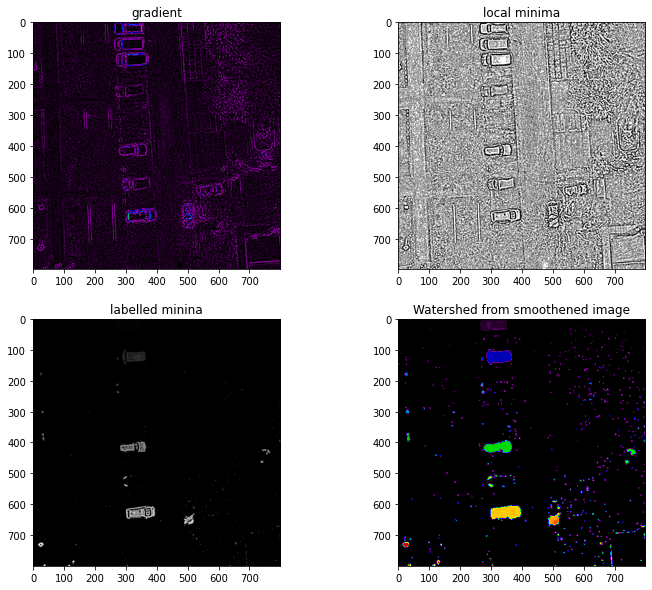

In [15]:
# Your work here
#Smooth the potsdam_gray image and compute its Laplacian gradient
kernel = np.ones((5,5),np.float32)/25
smooth_image01 = cv2.filter2D(np.uint8(potsdam_gray),-1,kernel)

kernel = (np.array([[0, 1, 0], [1, -4, 1], [0,1,0]])).astype(np.float32)
laplacian_gradient01 = cv2.filter2D(np.uint8(smooth_image01),-1,kernel)

#find local minima
local_minima01 = extrema.local_minima(laplacian_gradient01)

# Label the local minima using the function
structure01 = np.ones((3, 3), dtype=np.int) # 4-connectivity
labeled_minima01, ncomponents = label(local_minima01, structure01)
    
# Compute the watershed segmentation of our gradient
watershed_result01 = watershed(laplacian_gradient01, labeled_minima01)



# Visualizing plots.
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.imshow(laplacian_gradient01, cmap=plt.cm.nipy_spectral)
plt.title('gradient')
plt.subplot(222)
plt.imshow(local_minima01,cmap='gray')
plt.title('local minima')
plt.subplot(223)
plt.imshow(labeled_minima01, cmap='gray')
plt.title('labelled minina')
plt.subplot(224)
plt.imshow(watershed_result01,cmap=plt.cm.nipy_spectral)
plt.title('Watershed from smoothened image')
plt.show()

#### Question 3.2)

To deal the oversegmentation problem of watershed segmentations, we can try other two solutions:

- use of a better image gradient

- marker watersheds: enforces local minima at the regions of interest; catchment basins are grown only from markers.


We first try to use a better image gradient. Open and vizualize the pre-computed gradient "potsdam_RGB_2_gradient.bmp", which was obtained using a deep learning based method. Then, compute the watershed segmentation from this gradient as done previously.

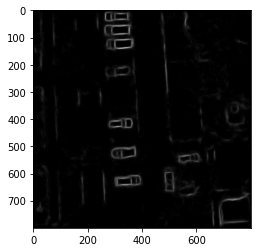

In [16]:
# with provided gradient
better_grad = plt.imread("potsdam_RGB_2_gradient.bmp")
better_grad = np.asarray(better_grad)
img_grad_one = better_grad[:,:,0:1]
img_grad_one = img_grad_one.reshape(800,800)
plt.imshow(better_grad)

/usr/local/lib/python3.8/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


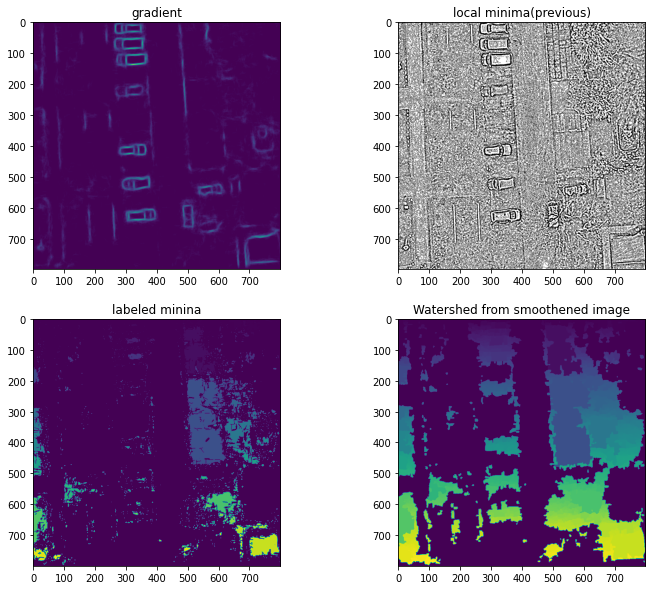

In [17]:
# Your work here
# #Smooth the potsdam_gray image and compute its Laplacian gradient
# kernel = np.ones((5,5),np.float32)/25
# smooth_image01 = cv2.filter2D(np.uint8(potsdam_gray),-1,kernel)

# kernel = (np.array([[0, 1, 0], [1, -4, 1], [0,1,0]])).astype(np.float32)
# laplacian_gradient01 = cv2.filter2D(np.uint8(smooth_image01),-1,kernel)

#find local minima
local_minima02 = extrema.local_minima(img_grad_one)

# Label the local minima using the function
structure02 = np.ones((3, 3), dtype=np.int) # 4-connectivity
labeled_minima02, ncomponents02 = label(local_minima02, structure02)
    
# Compute the watershed segmentation of our gradient
watershed_result02 = watershed(img_grad_one, labeled_minima02)


# Visualizing plots.
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.imshow(img_grad_one)
plt.title('gradient')
plt.subplot(222)
plt.imshow(local_minima01, cmap="gray")
plt.title('local minima(previous)')
plt.subplot(223)
plt.imshow(labeled_minima02)
plt.title('labeled minina')
plt.subplot(224)
plt.imshow(watershed_result02)
plt.title('Watershed from smoothened image')
plt.show()

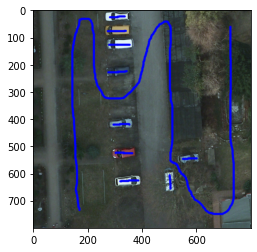

In [18]:
markered = plt.imread("potsdam_RGB_2_markers_2.bmp")
markered = np.asarray(markered)
plt.imshow(markered)

# markered_one = markered[:,:,0:1]
marker_gray = to_gray(markered)

/usr/local/lib/python3.8/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


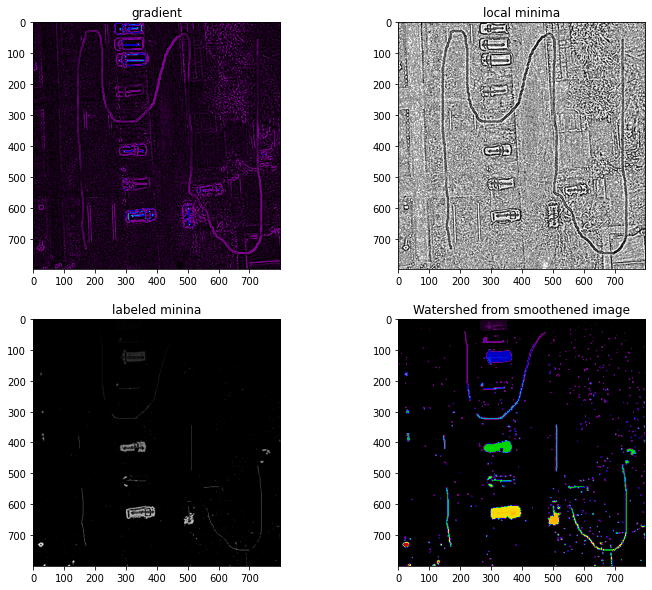

In [19]:
# Your work here
#Smooth the potsdam_gray image and compute its Laplacian gradient
kernel = np.ones((5,5),np.float32)/25
smooth_image03 = cv2.filter2D(np.uint8(marker_gray),-1,kernel)

kernel = (np.array([[0, 1, 0], [1, -4, 1], [0,1,0]])).astype(np.float32)
laplacian_gradient03 = cv2.filter2D(np.uint8(smooth_image03),-1,kernel)

#find local minima
local_minima03 = extrema.local_minima(laplacian_gradient03)

# Label the local minima using the function
structure03 = np.ones((3, 3), dtype=np.int) # 4-connectivity
labeled_minima03, ncomponents03 = label(local_minima03, structure03)
    
# Compute the watershed segmentation of our gradient
watershed_result03 = watershed(laplacian_gradient03, labeled_minima03)



# Visualizing plots.
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.imshow(laplacian_gradient03, cmap=plt.cm.nipy_spectral)
plt.title('gradient')
plt.subplot(222)
plt.imshow(local_minima03,cmap='gray')
plt.title('local minima')
plt.subplot(223)
plt.imshow(labeled_minima03, cmap='gray')
plt.title('labeled minina')
plt.subplot(224)
plt.imshow(watershed_result03,cmap=plt.cm.nipy_spectral)
plt.title('Watershed from smoothened image')
plt.show()

Three watershed were prepared in the above exercise:
* watershed with computed gradient
* watershed with given gradient
* watershed with provided markers

Among these three cases we observed that the one with marker and without it provided more or less similar result but wastershed with provided gradient shows better seperated objects in the image. 

### **Exo 4: Let's try a another advanced method**

Now, let's experiment the graph-based method from the paper *Efficient Graph-Based Image Segmentation by Felzenszwalb & Huttenlocher*, by using the function *felzenszwalb* of the skimage library:

```
felzenszwalb(img, scale=5000, sigma=0.8)
```
where:
- scale is the constant *k* parameter (larger *k* leads to larger regions in the segmentation)
- sigma is the width of the Gaussian smooting applied to the input image

Try different values of *k* and *sigma*. Apply to segment the RGB Potsdam image.

Observe and comment on your obtained results.




/tmp/ipykernel_3664/975699288.py:10: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  plt.imshow(felz(potsdam_rgb,5000,0.8))
/tmp/ipykernel_3664/975699288.py:13: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  plt.imshow(felz(potsdam_rgb,5000,0.5))
/tmp/ipykernel_3664/975699288.py:16: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  plt.imshow(felz(potsdam_rgb,5000,0.3))
/tmp/ipykernel_3664/975699288.py:19: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  plt.imshow(felz(potsdam_rgb,1000,0.8))
/tmp/ipykernel_3664/975699288.py:22: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multic

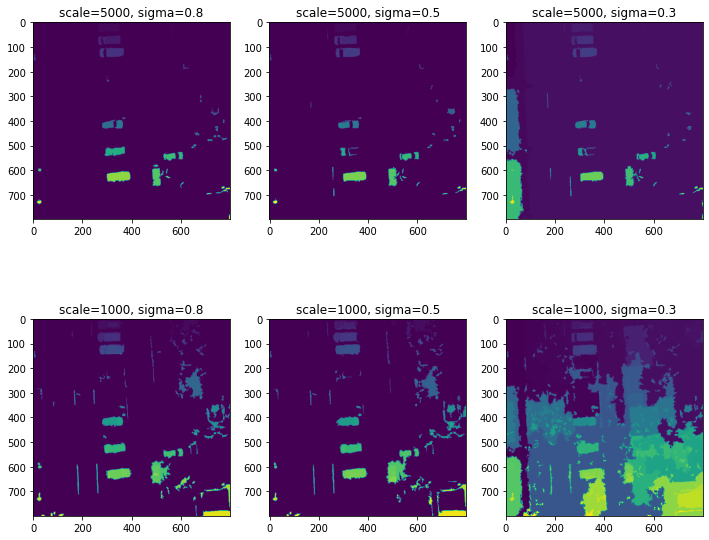

In [20]:
# your work here
def felz(img,k,sig):
    segments = felzenszwalb(img, scale=k, sigma=sig, min_size=50)
    return segments



plt.figure(figsize=(12,10))
plt.subplot(231)
plt.imshow(felz(potsdam_rgb,5000,0.8))
plt.title('scale=5000, sigma=0.8')
plt.subplot(232)
plt.imshow(felz(potsdam_rgb,5000,0.5))
plt.title('scale=5000, sigma=0.5')
plt.subplot(233)
plt.imshow(felz(potsdam_rgb,5000,0.3))
plt.title('scale=5000, sigma=0.3')
plt.subplot(234)
plt.imshow(felz(potsdam_rgb,1000,0.8))
plt.title('scale=1000, sigma=0.8')
plt.subplot(235)
plt.imshow(felz(potsdam_rgb,1000,0.5))
plt.title('scale=1000, sigma=0.5')
plt.subplot(236)
plt.imshow(felz(potsdam_rgb,1000,0.3))
plt.title('scale=1000, sigma=0.3')
plt.show()

As we know scale determines the region of segmentation whereas sigma is the width of the Gaussian smooting applied to the input image. It was seen that larger the value of sigma better was the smoothing of the segmented regions and vice versa. Similarly when scale was increases larger segmentation were created compared to the lesser value. 

Thus comparatively better result was achieved with larger scale value with higher sigma.

Thank you